# Importación de librerias a manejar

In [123]:
import empiricaldist
#import janitor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import sklearn.metrics
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats as ss
import warnings
from IPython.core.display import display, HTML
import math

#Quitar advertencias en los codigos
warnings.filterwarnings('ignore')

# Ver Datasets completos
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

pd.options.display.float_format = '{:.2f}'.format

# Importación de datos | Conociendo datos

In [124]:
df_train = pd.read_csv('data\\train_data.csv') # Caracteristicas de los productos  recomendaciones y la indicación del usuario
df_test = pd.read_csv('data\\test_challengue.csv') # Test Prueba

In [125]:
# Entendiendo la composición de los datos

print("Train Cantidad tipo variables")
print("--------------------------------")
t_1= (
    df_train
    .dtypes
    .value_counts()
)
print(t_1)
print("Observaciones df_train {}:".format(str(df_train.shape)))
print("--------------------------------")
print("Test | Prueba")
t_2 = (
    df_test
    .dtypes
    .value_counts()
)
print("--------------------------------")
print(t_2)
print("--------------------------------")

print("Observaciones df_test {}:".format(str(df_test.shape)))

Train Cantidad tipo variables
--------------------------------
object     10
float64     8
int64       3
bool        1
dtype: int64
Observaciones df_train (60430, 22):
--------------------------------
Test | Prueba
--------------------------------
object     10
float64     8
int64       3
dtype: int64
--------------------------------
Observaciones df_test (6714, 21):


In [126]:
print("----------------------------------------------------")
print("Train Nombre Columnas")
print("----------------------------------------------------")
print(df_train.columns)
print("----------------------------------------------------")
print("Train Test")
print("----------------------------------------------------")
print(df_test.columns)

----------------------------------------------------
Train Nombre Columnas
----------------------------------------------------
Index(['Unnamed: 0', 'PRODUCT_ID', 'RECOMMENDED_PRODUCT_ID', 'USER_LIKED',
       'RECOMENDATION_INDEX_ORDER', 'RECOMMENDATION_APPROVED_BY_USER',
       'RECOMMENDATION_DONE_BY_RT', 'RECOMMENDATION_DONE_BY_USER',
       'PRODUCT_SALES', 'RECOMMENDED_PRODUCT_SALES', 'PRODUCT_CATEGORY_PATH',
       'RECOMMENDED_PRODUCT_CATEGORY_PATH', 'PRODUCT_NAME',
       'PRODUCT_LONG_DESCRIPTION', 'PRODUCT_TRADEMARK', 'PRODUCT_MAKER',
       'PRODUCT_LAST_PRICE_SOLD', 'RECOMMENDED_PRODUCT_NAME',
       'RECOMMENDED_PRODUCT_LONG_DESCRIPTION', 'RECOMMENDED_PRODUCT_TRADEMARK',
       'RECOMMENDED_PRODUCT_MAKER', 'RECOMMENDED_PRODUCT_LAST_PRICE_SOLD'],
      dtype='object')
----------------------------------------------------
Train Test
----------------------------------------------------
Index(['Unnamed: 0', 'PRODUCT_ID', 'RECOMMENDED_PRODUCT_ID',
       'RECOMENDATION_INDEX_OR

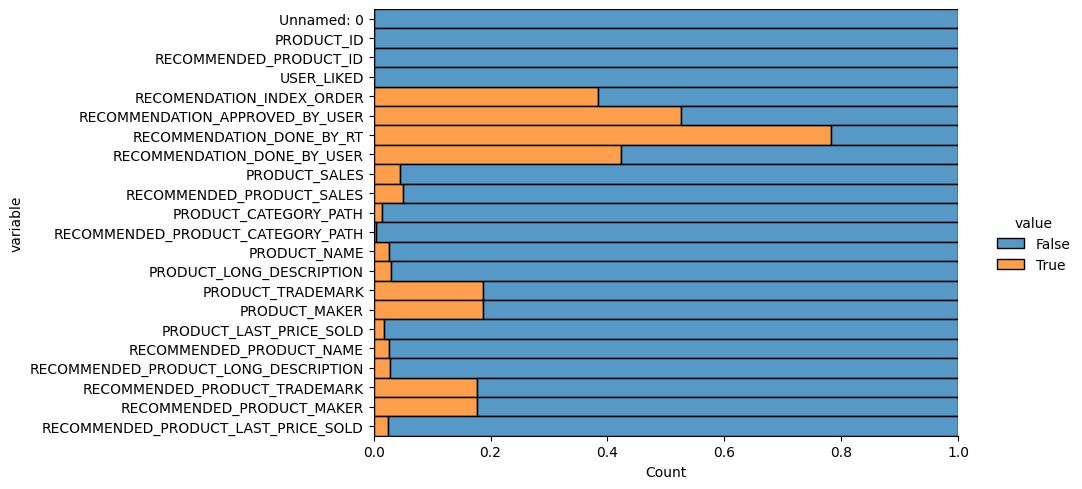

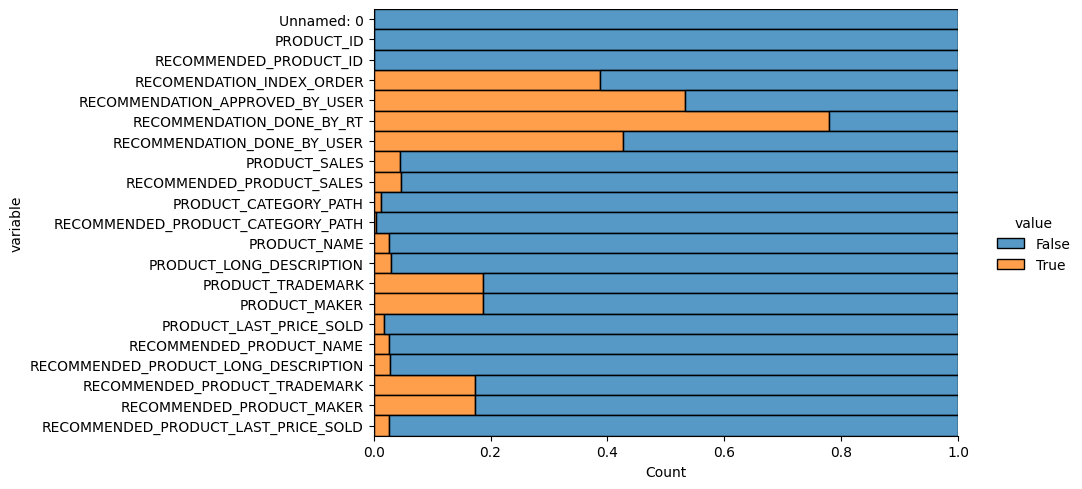

In [127]:
# Proporción de Nulos en los datos

(
    df_train
    .isnull()
    .melt()
    .pipe(
        lambda df: (
            sns.displot(
                data = df,
                y='variable',
                hue = 'value',
                multiple = 'fill',
                aspect = 2
            )
        )
    )
)

(
    df_test
    .isnull()
    .melt()
    .pipe(
        lambda df: (
            sns.displot(
                data = df,
                y='variable',
                hue = 'value',
                multiple = 'fill',
                aspect = 2
            )
        )
    )
)

# Análisis descriptivos

In [128]:
# df_test.astype({'PRODUCT_NAME':'category',
#                 'PRODUCT_TRADEMARK':'category',
#                 'PRODUCT_MAKER':'category',
#                 'RECOMMENDED_PRODUCT_NAME':'category',
#                 'RECOMMENDED_PRODUCT_TRADEMARK':'category',
#                 'RECOMMENDED_PRODUCT_MAKER':'category'}). describe(include='category')

df_train.astype({'PRODUCT_NAME':'category',
                'RECOMMENDED_PRODUCT_NAME':'category',
                'USER_LIKED':'category',
                'PRODUCT_ID':'category',
                'RECOMMENDED_PRODUCT_ID':'category',
                'PRODUCT_CATEGORY_PATH':'category',
                'RECOMMENDED_PRODUCT_CATEGORY_PATH':'category'}). describe(include='category')


,PRODUCT_ID,RECOMMENDED_PRODUCT_ID,USER_LIKED,PRODUCT_CATEGORY_PATH,RECOMMENDED_PRODUCT_CATEGORY_PATH,PRODUCT_NAME,RECOMMENDED_PRODUCT_NAME
count,60430,60430,60430,59559,60226,58853,58872
unique,36067,35015,2,448,457,19138,17564
top,975228494,976326462,True,category-tree-co/despensa-y-productos-secos/sn...,category-tree-co/despensa-y-productos-secos/sn...,Takis Frituras Sabor Fuego,Takis Frituras Sabor Fuego
freq,23,28,54174,4465,4607,134,112


In [129]:
df_train_b = pd.DataFrame(df_train.groupby(['PRODUCT_ID','PRODUCT_NAME','PRODUCT_TRADEMARK','PRODUCT_MAKER','PRODUCT_CATEGORY_PATH']).size()).reset_index()
df_train_b[df_train_b['PRODUCT_ID'].astype(str).str.contains("975228494")]

,PRODUCT_ID,PRODUCT_NAME,PRODUCT_TRADEMARK,PRODUCT_MAKER,PRODUCT_CATEGORY_PATH,0
6915,975228494,Magnum Paleta Almendras,Magnum,Unilever,category-tree-co/comida-preparada/helados-y-po...,23


In [130]:
df_train_b = pd.DataFrame(df_train.groupby(['RECOMMENDED_PRODUCT_ID','RECOMMENDED_PRODUCT_NAME','RECOMMENDED_PRODUCT_TRADEMARK','RECOMMENDED_PRODUCT_MAKER','RECOMMENDED_PRODUCT_CATEGORY_PATH']).size()).reset_index()
df_train_b[df_train_b['RECOMMENDED_PRODUCT_ID'].astype(str).str.contains("976326462")]

,RECOMMENDED_PRODUCT_ID,RECOMMENDED_PRODUCT_NAME,RECOMMENDED_PRODUCT_TRADEMARK,RECOMMENDED_PRODUCT_MAKER,RECOMMENDED_PRODUCT_CATEGORY_PATH,0
12815,976326462,Sabritas-Cheetos Snack Flaming Hot,Sabritas-Cheetos,PepsiCo,category-tree-co/despensa-y-productos-secos/sn...,28


## Descripción Categórica
- De los 60430 registros contamos con 58853 registros con nombre.
- Se cuenta con, 36067 Valores únicos de producto, los cuales se han recomendado 35015, es decir que por cada producto que se hace recomendación, se recomienda 1 producto aproximadamente
- El producto para el cual se hacen más recomendaciones es ***Magnum Paleta Almendras***
- el producto que se recomienda más con la venta de otro PRODUCT_ID es ***Sabritas-Cheetos Snack Flaming Hot****
- el porcentaje de gusto de las recomendaciones dadas es positivo, este porcentaje se distribuye en 0,89 con Gusto positivo y un 0.11 que no gusta de la recomendación

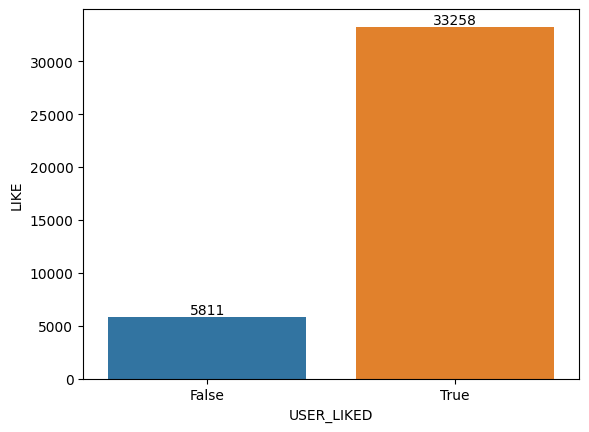

In [131]:
df_pro = df_train.groupby(['USER_LIKED',] \
        ).apply(lambda x: pd.Series( \
                                    { \
                                    'LIKE': len(x['PRODUCT_ID'].unique())
                                }))
df_pro= df_pro.reset_index()

ax = sns.barplot(
        data=df_pro,
        x='USER_LIKED',
        y='LIKE'
    )

for i in ax.containers:
    ax.bar_label(i,)

# Distribución de productos A (Producto comprado (Al que se le hizo la recomendación)) B(Producto recomendado)

![kernelspec](capturas/Captura%20de%20pantalla%202022-10-12%20143500.png)

----------------------------------------------------------------


----------------------------------------------------------------
    Cantidad Producto recomendacion (A)  Producto Recomendado(B)
0                                     4                       23
1                                     2                       21
2                                     3                       20
3                                     2                       19
4                                     4                       18
5                                     4                       17
6                                     4                       16
7                                     8                       15
8                                    11                       14
9                                    17                       13
10                                   27                       12
11                                   41                       11
12                                   40                       10
13                       

----------------------------------------------------------------
PROMEDIO: 1.6754928327834309
MEDIANA: 1.0
MODA: 0    1
Name: #_PRODUC_RECOME, dtype: int64
----------------------------------------------------------------


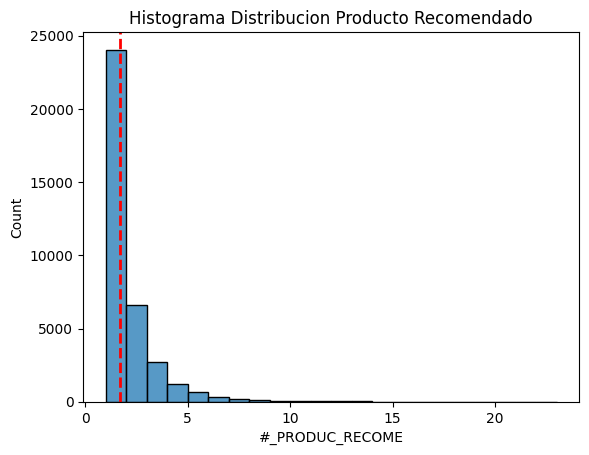

In [132]:
df_train_hist = df_train.groupby(['PRODUCT_ID',] \
        ).apply(lambda x: pd.Series( \
                                    { \
                                    '#_PRODUC_RECOME': len(x['RECOMMENDED_PRODUCT_ID'].unique())
                                }))
df_train_hist= df_train_hist.reset_index()

#Distribucion de las recomendaciones
sns.histplot(
    data=df_train_hist ,
    x='#_PRODUC_RECOME',
    binwidth=1
).set_title('Histograma Distribucion Producto Recomendado')

plt.axvline(
    x = df_train_hist['#_PRODUC_RECOME'].mean(),
    color='red',
    linestyle = 'dashed',
    linewidth = 2
)

print('----------------------------------------------------------------')
display(HTML('<h1>Cantidad de productos que tienen más de una recomendación!</h1>'))
print('----------------------------------------------------------------')
df_train_hist_l = df_train_hist['#_PRODUC_RECOME'].value_counts().reset_index()
df_train_hist_l = df_train_hist_l.rename(columns = {'#_PRODUC_RECOME':'Cantidad Producto recomendacion (A)','index': 'Producto Recomendado(B)'})
df_train_hist_l = df_train_hist_l.reindex(columns = ['Cantidad Producto recomendacion (A)','Producto Recomendado(B)'])
print(df_train_hist_l.sort_values(by=['Producto Recomendado(B)'], ascending=False).reset_index(drop=True))
print('----------------------------------------------------------------')
display(HTML('<h1>Medidas de tendencia central</h1>'))
print('----------------------------------------------------------------')
print("PROMEDIO: {}".format(df_train_hist['#_PRODUC_RECOME'].mean()))
print("MEDIANA: {}".format(df_train_hist['#_PRODUC_RECOME'].median()))
print("MODA: {}".format(df_train_hist['#_PRODUC_RECOME'].mode()))
print('----------------------------------------------------------------')


# Armar un clasificador que indique si un producto es una buena recomendación similar para otro.

In [133]:
df_train_prob = df_train.groupby(['RECOMMENDED_PRODUCT_ID','RECOMMENDED_PRODUCT_NAME','USER_LIKED'] \
        ).apply(lambda x: pd.Series( \
                                    { \
                                    'RECOMMENDED_PRODUCT_CATEGORY_PATH': x['RECOMMENDED_PRODUCT_CATEGORY_PATH'].unique(),
                                    'CANTIDAD': len(x['PRODUCT_ID'].unique()),
                                    'PRODUCT_ID': sorted(x['PRODUCT_ID'].unique()),
                                    #'PRODUCT_NAME': x['PRODUCT_NAME'].unique(),
                                    'PRODUCT_CATEGORY_PATH': x['PRODUCT_CATEGORY_PATH'].unique(),
                                    'IGUAL_CATEGORIA': x['PRODUCT_CATEGORY_PATH'].unique() == x['RECOMMENDED_PRODUCT_CATEGORY_PATH'].unique()
                                }))
df_train_prob = df_train_prob.reset_index()
df_train_prob = df_train_prob.explode('IGUAL_CATEGORIA')

In [134]:
df_train_prob['USER_LIKED'].unique()

probabilidad_recomendacion = (
    df_train_prob
    .assign(is_liked = lambda df : df['USER_LIKED'].replace(['True',
    'False'],[1,0]))
)
probabilidad_recomendacion['is_liked'] = probabilidad_recomendacion['is_liked'].astype(int)
# probabilidad_recomendacion['RECOMMENDED_PRODUCT_ID'] = probabilidad_recomendacion['RECOMMENDED_PRODUCT_ID'].astype(str)
probabilidad_recomendacion.sample(frac= 0.00008)

,RECOMMENDED_PRODUCT_ID,RECOMMENDED_PRODUCT_NAME,USER_LIKED,RECOMMENDED_PRODUCT_CATEGORY_PATH,CANTIDAD,PRODUCT_ID,PRODUCT_CATEGORY_PATH,IGUAL_CATEGORIA,is_liked
10887,975373942,Sidral Mundet Refresco Sabor Manzana 3L,True,[category-tree-co/bebidas/gaseosas/gaseosas],1,[979237284],[category-tree-co/bebidas/jugos-y-néctares/jugos],False,1
2303,975106997,Paketaxo Botana Surtida Xtra Flamin Hot,True,[category-tree-co/despensa-y-productos-secos/s...,2,"[975076703, 976229026]",[category-tree-co/despensa-y-productos-secos/s...,True,1
2752,975120850,Fabuloso Limpiador Multiusos Fragancia a Mar F...,True,[category-tree-co/cuidado-y-limpieza-del-hogar...,5,"[975122150, 975122745, 975123611, 975123612, 9...",[category-tree-co/cuidado-y-limpieza-del-hogar...,True,1


#### Probabilidad de cada producto segun la recomendación dada
La probabilidad de cualquier tipo de evento — simple, compuesto, independiente, dependiente — siempre sigue la misma fórmula básica:

![1](capturas/Captura%20de%20pantalla%202022-10-12%20183656.png)

In [135]:
# probabilidad = empiricaldist.Cdf.from_seq(
#     probabilidad_recomendacion['RECOMMENDED_PRODUCT_ID'],
#     normalize=True
# )
# probabilidad = probabilidad.reset_index(name='PROB')
# probabilidad = probabilidad.rename(columns = {'index':'RECOMMENDED_PRODUCT_ID_Y'})
# #probabilidad['acumulado'] = probabilidad['PROB'].diff()
# probabilidad.head(5)

probabilidad = probabilidad_recomendacion
probabilidad['PROB'] = 1 -  probabilidad['CANTIDAD']/probabilidad['CANTIDAD'].nunique()
q_probabilidad = pd.DataFrame(probabilidad['PROB'].value_counts()).reset_index()
q_probabilidad = q_probabilidad.rename(columns = {'PROB':'Cantidad Producto Recomendado','index': 'PROB'})
q_probabilidad.sort_values(by=['PROB'], ascending=False).reset_index(drop=True)


,PROB,Cantidad Producto Recomendado
0,0.96,25605
1,0.91,7426
2,0.87,3268
3,0.83,1637
4,0.78,858
5,0.74,477
6,0.70,294
7,0.65,207
8,0.61,131
9,0.57,92


# Rango límites del 65 % de los datos

Con este rango ya nos aseguramos que estamos capturando el 65% de nuestros datos 

In [136]:
#superior
superior =probabilidad['PROB'].mean() +probabilidad['PROB'].std()

inferior = probabilidad['PROB'].mean() -probabilidad['PROB'].std()

print(superior,inferior)

0.9955902471468407 0.8452229907459692


In [137]:
probabilidad.sample(frac=0.00008)

,RECOMMENDED_PRODUCT_ID,RECOMMENDED_PRODUCT_NAME,USER_LIKED,RECOMMENDED_PRODUCT_CATEGORY_PATH,CANTIDAD,PRODUCT_ID,PRODUCT_CATEGORY_PATH,IGUAL_CATEGORIA,is_liked,PROB
8157,975212676,Marinela-Pinguinos Pastelitos Sabor a Chocolate,False,[category-tree-co/despensa-y-productos-secos/p...,2,"[975188784, 975210043]",[category-tree-co/despensa-y-productos-secos/p...,True,0,0.91
18439,977144374,Cashew Dream Coco Dream Cashew Agua De Coco,True,[category-tree-co/bebidas/aguas/agua-saborizada],1,[977147463],[category-tree-co/bebidas/aguas/agua-saborizada],True,1,0.96
15565,975779215,Quaker Galletas de Avena Frutos Rojos,True,[category-tree-co/despensa-y-productos-secos/s...,1,[975779363],[category-tree-co/despensa-y-productos-secos/s...,True,1,0.96


# Clasificador

Este clasificador toma las siguientes variables
- Rango de los límites de la cantidad de los datos del 65% ***PROB[0.99,0.84]***
- Si la categoría de la recomendación es igual al categoría del producto recomendado
- si al usuario le gusto o no la recomendación

In [138]:
probabilidad_final = probabilidad

def recomendacion(row):
    if row['PROB'] < 1 and row['PROB'] > 0.87 and row['IGUAL_CATEGORIA'] == False and row['is_liked'] == 0:
        return "1. No Es Buena Recomendacion"
    elif row['PROB'] < 1 and row['PROB'] > 0.87 and row['IGUAL_CATEGORIA'] == True and row['is_liked'] == 1:
        return "2. Recomendacion Aceptable"
    elif row['PROB'] < 0.87 and row['IGUAL_CATEGORIA'] == False :
        return "3. Recomendacion Buena"
    elif row['PROB'] < 0.87 and row['IGUAL_CATEGORIA'] == True :
        return "4. Excelente recomendacion"
    else:
        return"1. No Es Buena Recomendacion"

probabilidad_final['recomendacion'] = probabilidad_final.apply(recomendacion,axis=1)

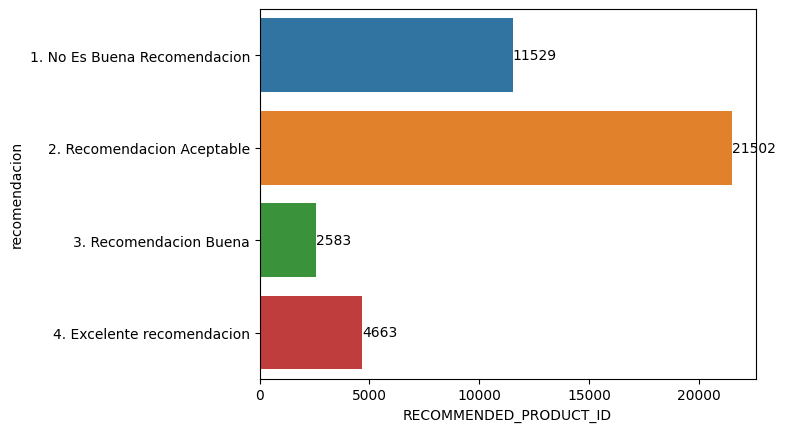

In [139]:
distri_sns = probabilidad_final.groupby(['recomendacion']).agg({'RECOMMENDED_PRODUCT_ID':'count'})
distri_sns = pd.DataFrame(distri_sns).reset_index()
distri_sns 
ax = sns.barplot(x='RECOMMENDED_PRODUCT_ID', y='recomendacion', data=distri_sns)
for i in ax.containers:
    ax.bar_label(i,)


#### Ejemplo de clarificación para un producto, en este caso analizaremos el producto ***975228494 - Magnum Paleta Almendras*** Nuestro producto TOP

In [140]:
probabilidad_final[probabilidad_final['RECOMMENDED_PRODUCT_ID'] == 975228494]

,RECOMMENDED_PRODUCT_ID,RECOMMENDED_PRODUCT_NAME,USER_LIKED,RECOMMENDED_PRODUCT_CATEGORY_PATH,CANTIDAD,PRODUCT_ID,PRODUCT_CATEGORY_PATH,IGUAL_CATEGORIA,is_liked,PROB,recomendacion
9325,975228494,Magnum Paleta Almendras,False,[category-tree-co/comida-preparada/helados-y-p...,2,"[975231500, 976486020]",[category-tree-co/comida-preparada/helados-y-p...,True,0,0.91,1. No Es Buena Recomendacion
9326,975228494,Magnum Paleta Almendras,True,[category-tree-co/comida-preparada/helados-y-p...,4,"[975228811, 975499533, 976486021, 976486036]",[category-tree-co/comida-preparada/helados-y-p...,True,1,0.83,4. Excelente recomendacion


### Realizamos un Explode a la tabla con la lista, la cual nos da un panorama más amplio del comportamiento de las recomendaciones para este producto

In [141]:
df_train_produc_id = pd.DataFrame(df_train.groupby(['PRODUCT_ID','PRODUCT_NAME']).size()).reset_index()
df_probabilidad = probabilidad_final.explode('PRODUCT_ID')
df_probabilidad = df_probabilidad.merge(df_train_produc_id, left_on=['PRODUCT_ID'], right_on=['PRODUCT_ID'], how='left')

In [142]:
df_probabilidad[df_probabilidad['RECOMMENDED_PRODUCT_ID'] == 975228494]

,RECOMMENDED_PRODUCT_ID,RECOMMENDED_PRODUCT_NAME,USER_LIKED,RECOMMENDED_PRODUCT_CATEGORY_PATH,CANTIDAD,PRODUCT_ID,PRODUCT_CATEGORY_PATH,IGUAL_CATEGORIA,is_liked,PROB,recomendacion,PRODUCT_NAME,0
20068,975228494,Magnum Paleta Almendras,False,[category-tree-co/comida-preparada/helados-y-p...,2,975231500,[category-tree-co/comida-preparada/helados-y-p...,True,0,0.91,1. No Es Buena Recomendacion,Helados Holanda Helado Napolitano,8.00
20069,975228494,Magnum Paleta Almendras,False,[category-tree-co/comida-preparada/helados-y-p...,2,976486020,[category-tree-co/comida-preparada/helados-y-p...,True,0,0.91,1. No Es Buena Recomendacion,Helados Holanda Helado Napolitano,14.00
20070,975228494,Magnum Paleta Almendras,True,[category-tree-co/comida-preparada/helados-y-p...,4,975228811,[category-tree-co/comida-preparada/helados-y-p...,True,1,0.83,4. Excelente recomendacion,Helados Nestlé Paleta Crunch,9.00
20071,975228494,Magnum Paleta Almendras,True,[category-tree-co/comida-preparada/helados-y-p...,4,975499533,[category-tree-co/comida-preparada/helados-y-p...,True,1,0.83,4. Excelente recomendacion,Nesquik Paleta de Helado Sabor Chocolate,5.00
20072,975228494,Magnum Paleta Almendras,True,[category-tree-co/comida-preparada/helados-y-p...,4,976486021,[category-tree-co/comida-preparada/helados-y-p...,True,1,0.83,4. Excelente recomendacion,Helados Holanda Helado Vainilla,4.00
20073,975228494,Magnum Paleta Almendras,True,[category-tree-co/comida-preparada/helados-y-p...,4,976486036,[category-tree-co/comida-preparada/helados-y-p...,True,1,0.83,4. Excelente recomendacion,Magnum Paleta Doble Chocolate,4.00


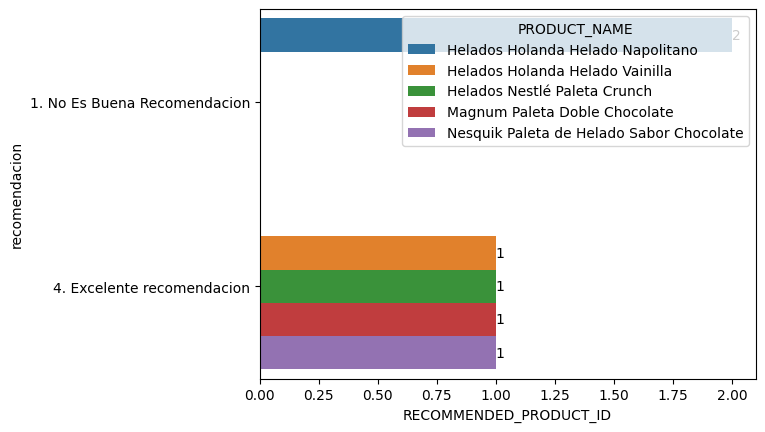

In [143]:
muestra_prob = df_probabilidad[df_probabilidad['RECOMMENDED_PRODUCT_ID'] == 975228494]
muestra_prob = muestra_prob.groupby(['recomendacion','PRODUCT_NAME']).agg({'RECOMMENDED_PRODUCT_ID':'count'})
muestra_prob = pd.DataFrame(muestra_prob).reset_index()
muestra_prob

display(HTML('<h1>Clasificación de recomendación para el producto TOP!</h1>'))
ax = sns.barplot(x='RECOMMENDED_PRODUCT_ID', y='recomendacion',hue='PRODUCT_NAME', data=muestra_prob,capsize=5, width=.9)
for i in ax.containers:
    ax.bar_label(i,)



#### Las Recomendaciones que no son buenas son las que no tienen una buena calificación por el gusto del usuario, según lo que planteamos con el modelo de clasificación

# Tabla de combinaciones de probabilidad, con su recomendación para verificar más productos según lo que se asigne

In [144]:
df_train_produc_id = pd.DataFrame(df_train.groupby(['PRODUCT_ID','PRODUCT_NAME']).size()).reset_index()
df_train_produc_recomed_id = pd.DataFrame(df_train.groupby(['RECOMMENDED_PRODUCT_ID','RECOMMENDED_PRODUCT_NAME']).size()).reset_index()
df_probabilidad_prod = df_probabilidad.reindex(columns = ['PRODUCT_ID','RECOMMENDED_PRODUCT_ID','recomendacion'])

df_probabilidad_prod = df_probabilidad_prod.merge(df_train_produc_id, left_on=['PRODUCT_ID'],right_on=['PRODUCT_ID'], how='left')
df_probabilidad_prod = df_probabilidad_prod.merge(df_train_produc_recomed_id, left_on=['RECOMMENDED_PRODUCT_ID'],right_on=['RECOMMENDED_PRODUCT_ID'], how='left')
df_probabilidad_prod = df_probabilidad_prod.reindex(columns = ['recomendacion','PRODUCT_ID','PRODUCT_NAME','RECOMMENDED_PRODUCT_ID','RECOMMENDED_PRODUCT_NAME'])
df_probabilidad_prod.sample(frac= 0.0001)

,recomendacion,PRODUCT_ID,PRODUCT_NAME,RECOMMENDED_PRODUCT_ID,RECOMMENDED_PRODUCT_NAME
62149,4. Excelente recomendacion,981016830,Coca-Cola Original - Refresco Sabor 1.25 L,981006047,Coca-Cola Original Gaseosa Sabor Cola
70567,3. Recomendacion Buena,1563188835,Liderclean Hisópos de Bambú,1563188833,Hisopos de Algodón Lidernova Mango de Bambú
10158,2. Recomendacion Aceptable,975141593,Rexona Desodorante en Aerosol Bamboo,975141596,Rexona Antitranspirante Motion Sense Sexy Bouq...
9307,3. Recomendacion Buena,975050670,Lala Leche Entera Fresca,975130835,Lala Leche Entera
22287,1. No Es Buena Recomendacion,975276106,Stacys Pita Chips Original,975276123,Late July Totopos Multigrano Sal de Mar
2941,4. Excelente recomendacion,977883058,KIR Jamón Americano de Pavo,975065255,KIR Jamón De Pavo Lunch
18833,3. Recomendacion Buena,975228494,Magnum Paleta Almendras,975228217,Bimbo Donas Azucaradas


# Clasificador en toda la tabla

Se anexa el clasificador a toda la tabla de ***TF_TRAIN***

In [145]:
df_train_f_prob = df_train.merge(df_probabilidad_prod, left_on=['RECOMMENDED_PRODUCT_ID','PRODUCT_ID'],right_on=['RECOMMENDED_PRODUCT_ID','PRODUCT_ID'], how='left')
df_train_f_prob['recomendacion'] = df_train_f_prob['recomendacion'].fillna('1. No Es Buena Recomendacion')

#### Distrubucion de la recomendacion para toda la tabla ***TRAIN***

In [146]:
df_train_f_prob_distri = df_train_f_prob.groupby(['recomendacion'] \
        ).apply(lambda x: pd.Series( \
                                    { \
                                    'PRODUCT_ID': len(x['PRODUCT_ID'].unique())
                                }))
df_train_f_prob_distri.sort_values(by=['recomendacion'], ascending=False).reset_index()

,recomendacion,PRODUCT_ID
0,4. Excelente recomendacion,11842
1,3. Recomendacion Buena,6211
2,2. Recomendacion Aceptable,21511
3,1. No Es Buena Recomendacion,12709


# Ejemplo producto TOP

In [147]:
nombre = 'Magnum Paleta Almendras' ## Insertar el producto a verificar
df_train_f_prob_t = df_train_f_prob[df_train_f_prob['PRODUCT_NAME_x'] == nombre].head(10)
prueba = df_train_f_prob_t.reindex(columns = ['recomendacion','PRODUCT_ID','PRODUCT_NAME_x','PRODUCT_TRADEMARK','RECOMMENDED_PRODUCT_ID','RECOMMENDED_PRODUCT_NAME_x','RECOMMENDED_PRODUCT_TRADEMARK','RECOMMENDED_PRODUCT_SALES'])
prueba

,recomendacion,PRODUCT_ID,PRODUCT_NAME_x,PRODUCT_TRADEMARK,RECOMMENDED_PRODUCT_ID,RECOMMENDED_PRODUCT_NAME_x,RECOMMENDED_PRODUCT_TRADEMARK,RECOMMENDED_PRODUCT_SALES
167,4. Excelente recomendacion,977554812,Magnum Paleta Almendras,Magnum,977145187,Cornetto Copa Brownie y Vainilla,Cornetto,683.00
997,4. Excelente recomendacion,982178684,Magnum Paleta Almendras,Magnum,975076512,Magnum Paleta Multipack Mini Almendras,Magnum,253.00
2491,1. No Es Buena Recomendacion,977554812,Magnum Paleta Almendras,Magnum,977144871,Chips Ahoy! Galletas Ahoy,Chips Ahoy,415.00
2492,1. No Es Buena Recomendacion,977554812,Magnum Paleta Almendras,Magnum,977144871,Chips Ahoy! Galletas Ahoy,Chips Ahoy,415.00
3164,3. Recomendacion Buena,975228494,Magnum Paleta Almendras,Magnum,975290112,Bimbo Panquecitos con Chispas Sabor a Chocolate,Bimbo,287.00
3165,3. Recomendacion Buena,975228494,Magnum Paleta Almendras,Magnum,975290112,Bimbo Panquecitos con Chispas Sabor a Chocolate,Bimbo,287.00
3166,4. Excelente recomendacion,975228494,Magnum Paleta Almendras,Magnum,975290112,Bimbo Panquecitos con Chispas Sabor a Chocolate,Bimbo,287.00
3167,3. Recomendacion Buena,975228494,Magnum Paleta Almendras,Magnum,975290112,Bimbo Panquecitos con Chispas Sabor a Chocolate,Bimbo,287.00
3168,3. Recomendacion Buena,975228494,Magnum Paleta Almendras,Magnum,975290112,Bimbo Panquecitos con Chispas Sabor a Chocolate,Bimbo,287.00
3169,3. Recomendacion Buena,975228494,Magnum Paleta Almendras,Magnum,975290112,Bimbo Panquecitos con Chispas Sabor a Chocolate,Bimbo,287.00


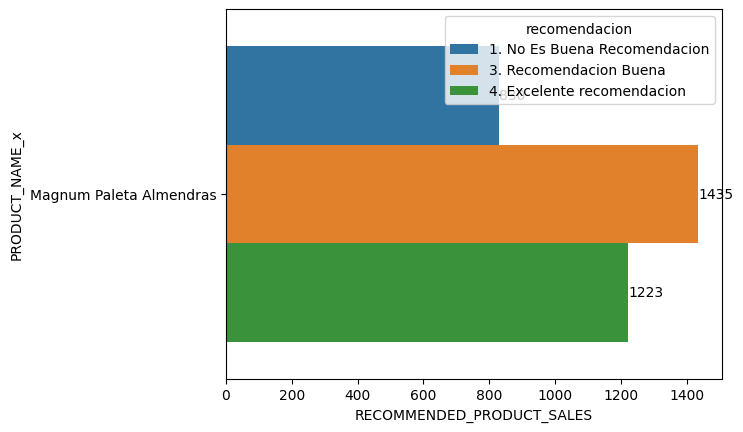

In [148]:
prueba_sns = prueba.groupby(['recomendacion','PRODUCT_NAME_x']).agg({'RECOMMENDED_PRODUCT_SALES':'sum'})
prueba_sns = pd.DataFrame(prueba_sns).reset_index()
prueba_sns
ax = sns.barplot(x='RECOMMENDED_PRODUCT_SALES', y='PRODUCT_NAME_x', hue='recomendacion', data=prueba_sns)

for i in ax.containers:
    ax.bar_label(i,)

 #### Se puede observar que para el producto top que son los ***Magnum Paleta Almendras***, las recomendaciones dentro de él no todas son buenas, dentro de sus clasificaciones hay malas combinaciones, teniendo en cuenta que la cantidad de órdenes del producto recomendado, se encuentra en la categoría BUENA, y las excelentes tiene pocos pedidos, si se distribuyen bien el producto tendría mejores combinaciones

# Predecir para test_challengue.csv

Ya que tenemos los nombres de las combinaciones realizaremos estas de acuerdo a los nombres

In [149]:
df_probabilidad_prod_test = df_probabilidad_prod
df_train_products = df_train.reindex(columns = ['PRODUCT_ID','PRODUCT_NAME','RECOMMENDED_PRODUCT_ID','RECOMMENDED_PRODUCT_NAME'])
df_train_products_prob = df_train_products.merge(df_probabilidad_prod_test, left_on=['PRODUCT_ID'], right_on=['PRODUCT_ID'], how='left')
df_test_f_prob = df_test.merge(df_train_products_prob, left_on=['PRODUCT_NAME','RECOMMENDED_PRODUCT_ID'],right_on=['PRODUCT_NAME_x','RECOMMENDED_PRODUCT_ID_y'], how='left')
df_test_f_prob['recomendacion'] = df_test_f_prob['recomendacion'].fillna('1. No Es Buena Recomendacion')

In [150]:
df_test_hist = df_test_f_prob.groupby(['recomendacion'] \
        ).apply(lambda x: pd.Series( \
                                    { \
                                    'PRODUCT_ID': len(x['PRODUCT_ID_x'].unique())
                                }))
df_test_hist= df_test_hist.reset_index()
df_test_hist

,recomendacion,PRODUCT_ID
0,1. No Es Buena Recomendacion,6029
1,2. Recomendacion Aceptable,47
2,3. Recomendacion Buena,43
3,4. Excelente recomendacion,82


In [151]:
nombre = 'Magnum Paleta Almendras' ## Insertar el producto a verificar
df_test_comb = df_test_f_prob.groupby(['PRODUCT_NAME','RECOMMENDED_PRODUCT_NAME','recomendacion'] \
        ).apply(lambda x: pd.Series( \
                                    { \
                                    'RECOMMENDED_PRODUCT_SALES': x['RECOMMENDED_PRODUCT_SALES'].unique().sum()
                                })).reset_index()
prueba_1 = df_test_comb[df_test_comb['PRODUCT_NAME'] == nombre].head(10)
prueba_1

,PRODUCT_NAME,RECOMMENDED_PRODUCT_NAME,recomendacion,RECOMMENDED_PRODUCT_SALES
3471,Magnum Paleta Almendras,Baileys Paleta Iced Baileys,1. No Es Buena Recomendacion,119.00
3472,Magnum Paleta Almendras,Big Donuts Dona Maple 85g,1. No Es Buena Recomendacion,148.00
3473,Magnum Paleta Almendras,Bolonia Paleta,1. No Es Buena Recomendacion,17.00
3474,Magnum Paleta Almendras,Coca-Cola Original Bebida Gaseosa,1. No Es Buena Recomendacion,886.00
3475,Magnum Paleta Almendras,Magnum Paleta Almendras Chocolate Blanco,4. Excelente recomendacion,259.00
3476,Magnum Paleta Almendras,Magnum Paleta Clásica,1. No Es Buena Recomendacion,94.00
3477,Magnum Paleta Almendras,Magnum Paleta Doble Chocolate,4. Excelente recomendacion,311.00
3478,Magnum Paleta Almendras,Magnum Praliné Paleta de Avellanas,1. No Es Buena Recomendacion,70.00
3479,Magnum Paleta Almendras,Mega Helados Nestlé,1. No Es Buena Recomendacion,37.00


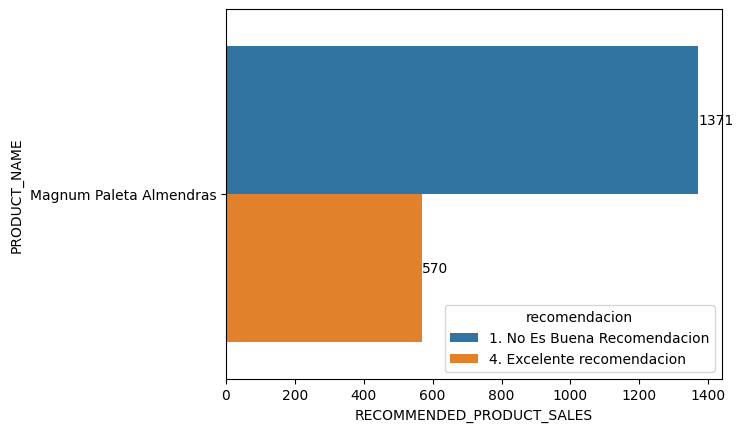

In [152]:
prueba_sns = prueba_1.groupby(['recomendacion','PRODUCT_NAME']).agg({'RECOMMENDED_PRODUCT_SALES':'sum'})
prueba_sns = pd.DataFrame(prueba_sns).reset_index()
ax = sns.barplot(x='RECOMMENDED_PRODUCT_SALES', y='PRODUCT_NAME', hue='recomendacion', data=prueba_sns)

for i in ax.containers:
    ax.bar_label(i,)

## Al realizar la misma prueba con la data de test nos podemos dar cuenta que los Magnum Paleta Almendras no son la mejor opción como una buena recomendación

# Algunos ejemplos de buenas recomendaciones

In [153]:
df_test_hist_ex = df_test_f_prob[df_test_f_prob['recomendacion'].str.contains('Excelente')]

df_test_hist_ex = df_test_f_prob.groupby(['PRODUCT_NAME','RECOMMENDED_PRODUCT_NAME'] \
        ).apply(lambda x: pd.Series( \
                                    { \
                                    'recomendacion': len(x['recomendacion'].unique())
                                }))
df_test_hist_ex= df_test_hist_ex.reset_index()
df_test_hist_ex.sample(frac=0.001)

,PRODUCT_NAME,RECOMMENDED_PRODUCT_NAME,recomendacion
5636,Tena Pants Nocturno Ropa Interior Desechable T...,Tena Pants Nocturno Ropa Interior Desechable M...,1
2433,Heb Salchicha Ahumada Original,Hill Country Fare Hcf Salchicha Ahumada Con Me...,1
4944,Sabritas-Cheetos Torciditos Sabor A Queso,Sabritas-Cheetos Torciditos Sabor Queso Tamaño...,1
5902,Victoria Vicky Cerveza Oscura con Chamoy y Tam...,Vicky Cerveza Chelada,1
5908,Vileda Guantes Style Medianos Par,Scotch Brite Guante Satinado Rojo,1
4935,Sabritas-Cheetos Botana Torciditos,Sabritas-Ruffles Botana Queso,1


# Predecir para test_challengue.csv

In [154]:
df_test_f_prob.to_csv('data/test_challengue_prob.csv')
df_test_f_prob.to_excel('data/test_challengue_prob.xlsx')